In [12]:
import pyodbc                  # package that connects notebook to database
import pandas as pd            # package for data manipulation
import seaborn as sns          # package for visualziation
import statsmodels.api as sm   # package for lm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact
import pandas as pd
import plotly.express as px
from ipywidgets import interact, Dropdown
import numpy as np

(2) In the next two code cells we prepare a string consisting of arguments for the server (the computer we have been working with) and the driver (this is software the allows us to connect to a database provided that the database follows certain Open Database Connectivity (ODBC) standards).

In [2]:
server = r'DESKTOP-Q6B5CSD\NAMNH'
database = 'AdventureWorksDW'
username = '' #Please keep it confidential.
password = '' #Please keep it confidential.
DRIVER= '{ODBC Driver 17 for SQL Server}'
connectionString = (
            f"DRIVER={{ODBC Driver 17 for SQL Server}};"
            f"SERVER={server};"
            f"UID={username};"
            f"PWD={password};"
            "Trusted_Connection=no;"
        )

In [3]:
cnxn = pyodbc.connect(connectionString)

In [4]:
pd.options.display.float_format = '{:.4f}'.format

# **Machine Learning Model (Demand Planning)**

In [5]:
dp_query = '''
-- Further Transformation
WITH CTE_FactInternetSales
AS (SELECT
  ProductKey,
  OrderDateKey,
  DueDateKey,
  ShipDateKey,
  CustomerKey,
  PromotionKey,
  CurrencyKey,
  SalesTerritoryKey,
  SalesOrderNumber,
  SalesAmount,
  TotalProductCost,
  TaxAmt,
  Freight,
  SalesAmount - TotalProductCost - TaxAmt - Freight AS Profit,
  (SalesAmount - TotalProductCost - TaxAmt - Freight) / SalesAmount AS ProfitMargin,
  CONVERT(date, OrderDate) AS OrderDate,
  CONVERT(date, DueDate) AS DueDate,
  CONVERT(date, ShipDate) AS ShipDate,
  IIF(ShipDate > DueDate, 'Late', 'Normal') AS ShipStatus,
  DATEDIFF(D, OrderDate, ShipDate) + 3 TimeToArrive,
  DATEDIFF(D, OrderDate, ShipDate) TimeToShip
FROM [AdventureWorksDW].dbo.FactInternetSales)
-------------------------------------------------------------------------------------------------------------------------------------------------------
,
CTE_DimDate
AS (SELECT
  DateKey,
  FullDateAlternateKey,
  DayNumberOfWeek,
  EnglishDayNameOfWeek,
  DayNumberOfMonth,
  DayNumberOfYear,
  WeekNumberOfYear,
  MonthNumberOfYear,
  EnglishMonthName AS MonthName,
  CalendarQuarter,
  CalendarYear,
  CalendarSemester,
  FiscalYear FiscalQuarter,
  FiscalSemester
FROM [AdventureWorksDW].dbo.DimDate)
-------------------------------------------------------------------------------------------------------------------------------------------------------
,
CTE_DimProduct
AS (SELECT
  ProductKey,
  ProductAlternateKey,
  EnglishProductName AS ProductName,
  EnglishProductCategoryName AS CategoryName,
  EnglishProductSubcategoryName AS SubcategoryName,
  CASE
    WHEN EnglishProductName LIKE '%,%' AND
      EnglishProductCategoryName = 'Bikes' THEN LEFT(EnglishProductName, CHARINDEX(' ', EnglishProductName) - 1)
    WHEN EnglishProductName LIKE '%,%' AND
      EnglishProductSubcategoryName LIKE '%Frames%' THEN LEFT(EnglishProductName, CHARINDEX('-', EnglishProductName) - 1)
    WHEN EnglishProductName LIKE '%,%' THEN LEFT(EnglishProductName, CHARINDEX(',', EnglishProductName) - 1)
    WHEN EnglishProductName LIKE '%/%' THEN LEFT(EnglishProductName, CHARINDEX('/', EnglishProductName) - 1)
    ELSE NULL
  END AS ModelName,
  SafetyStockLevel,
  ReorderPoint,
  Color,
  SizeRange,
  Weight
FROM [AdventureWorksDW].dbo.DimProduct
JOIN [AdventureWorksDW].dbo.DimProductSubcategory
  ON DimProduct.ProductSubcategoryKey = DimProductSubcategory.ProductSubcategoryKey
JOIN [AdventureWorksDW].dbo.DimProductCategory
  ON DimProductSubcategory.ProductCategoryKey = DimProductCategory.ProductCategoryKey
WHERE ListPrice IS NOT NULL)
-------------------------------------------------------------------------------------------------------------------------------------------------------

SELECT CategoryName, SubcategoryName, ModelName, OrderDate, ProductName, COUNT(*) as Quantity FROM CTE_FactInternetSales
JOIN CTE_DimDate 
ON CTE_FactInternetSales.OrderDateKey = CTE_DimDate.DateKey
JOIN CTE_DimProduct 
ON CTE_FactInternetSales.ProductKey = CTE_DimProduct.ProductKey
GROUP BY ProductName, CategoryName, SubcategoryName, ModelName, OrderDate
''' 
df_dp = pd.read_sql_query(dp_query, con=cnxn)

C:\Users\Windows.DESKTOP-Q6B5CSD\AppData\Local\Temp\ipykernel_7864\433020641.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_dp = pd.read_sql_query(dp_query, con=cnxn)


## **5.1 Chart and Trendline**

Choose from the following ModelNames:
1. Classic Vest
2. Half-Finger Gloves
3. Long-Sleeve Logo Jersey
4. Mountain-100
5. Mountain-200
6. Mountain-400-W
7. Mountain-500
8. Patch Kit
9. Racing Socks
10. Road-150
11. Road-250
12. Road-350-W
13. Road-550-W
14. Road-650
15. Road-750
16. Short-Sleeve Classic Jersey
17. Sport-100 Helmet
18. Touring-1000
19. Touring-2000
20. Touring-3000
21. Women's Mountain Shorts
Enter the number corresponding to the chosen ModelName: 16


C:\Users\Windows.DESKTOP-Q6B5CSD\AppData\Local\Temp\ipykernel_7864\1714109235.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_model_df['OrderDate'] = pd.to_datetime(chosen_model_df['OrderDate'])
C:\Users\Windows.DESKTOP-Q6B5CSD\AppData\Local\Temp\ipykernel_7864\1714109235.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  chosen_model_df_monthly = chosen_model_df.resample('M').sum()


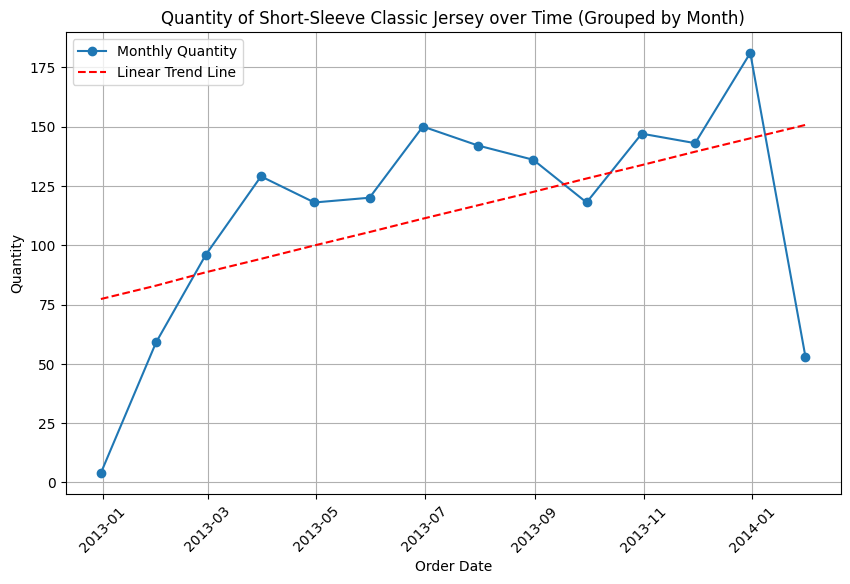

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_dp is your DataFrame

# Filter out rows where 'ModelName' is None
df_dp = df_dp[df_dp['ModelName'].notna()]

# Sort unique ModelNames
unique_model_names_sorted = sorted(df_dp['ModelName'].unique())

# Check if there are any ModelNames to choose from
if not unique_model_names_sorted:
    print("No ModelNames available.")
    exit()

# Print sorted unique ModelNames
print("Choose from the following ModelNames:")
for i, model_name in enumerate(unique_model_names_sorted, start=1):
    print(f"{i}. {model_name}")

# Take user input for the selected ModelName number
try:
    selected_model_number = int(input("Enter the number corresponding to the chosen ModelName: "))
    chosen_model = unique_model_names_sorted[selected_model_number - 1]
except (ValueError, IndexError):
    print("Invalid input. Please enter a valid number corresponding to the ModelName.")
    exit()

# Filter the DataFrame based on the chosen ModelName
chosen_model_df = df_dp[df_dp['ModelName'] == chosen_model]

# Convert OrderDate to datetime
chosen_model_df['OrderDate'] = pd.to_datetime(chosen_model_df['OrderDate'])

# Group by month and year
chosen_model_df = chosen_model_df.set_index('OrderDate')
chosen_model_df_monthly = chosen_model_df.resample('M').sum()

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(chosen_model_df_monthly.index, chosen_model_df_monthly['Quantity'], marker='o', linestyle='-', label='Monthly Quantity')

# Add linear trend line
x = np.arange(len(chosen_model_df_monthly))
y = chosen_model_df_monthly['Quantity'].values
m, b = np.polyfit(x, y, 1)
plt.plot(chosen_model_df_monthly.index, m * x + b, linestyle='--', color='r', label='Linear Trend Line')

plt.title(f'Quantity of {chosen_model} over Time (Grouped by Month)')
plt.xlabel('Order Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


### **5.2 LSTM Model**

Choose from the following ModelNames:  ['Classic Vest' 'Half-Finger Gloves' 'Long-Sleeve Logo Jersey'
 'Mountain-100' 'Mountain-200' 'Mountain-400-W' 'Mountain-500' 'Patch Kit'
 'Racing Socks' 'Road-150' 'Road-250' 'Road-350-W' 'Road-550-W' 'Road-650'
 'Road-750' 'Short-Sleeve Classic Jersey' 'Sport-100 Helmet'
 'Touring-1000' 'Touring-2000' 'Touring-3000' "Women's Mountain Shorts"]
Enter the ModelName from the list above: Classic Vest


C:\Users\Windows.DESKTOP-Q6B5CSD\AppData\Local\Temp\ipykernel_7864\3768868938.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_model_df['OrderDate'] = pd.to_datetime(chosen_model_df['OrderDate'])
C:\Users\Windows.DESKTOP-Q6B5CSD\AppData\Local\Temp\ipykernel_7864\3768868938.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  chosen_model_df_monthly = chosen_model_df.resample('M').sum()
C:\Users\Windows.DESKTOP-Q6B5CSD\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  su

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3117
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2559
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2039
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1562
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1140
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.0792
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.0541
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0421
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0453
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0596
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0725
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0755
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0698
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0601
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0506
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━

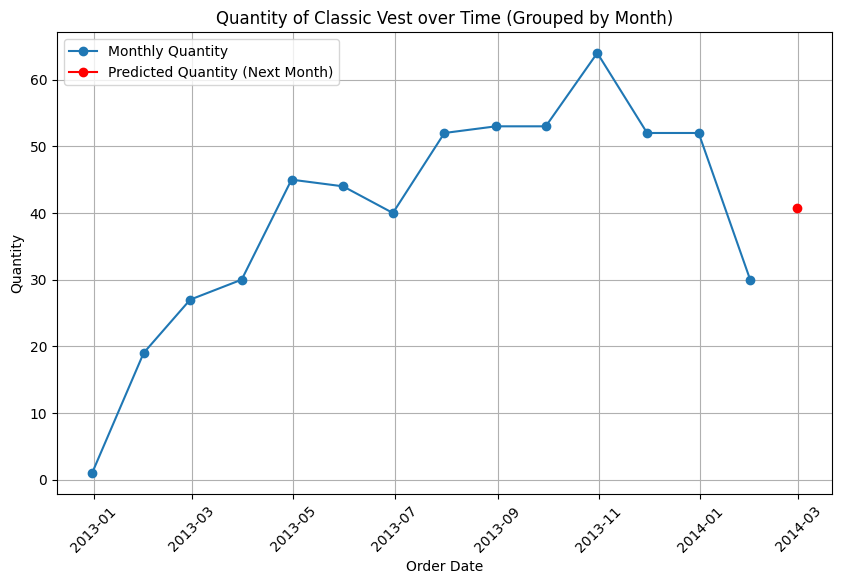

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming df_dp is your DataFrame

# Print unique ModelNames
unique_model_names = df_dp['ModelName'].unique()
print("Choose from the following ModelNames: ", unique_model_names)

# Take user input for the ModelName
chosen_model = input("Enter the ModelName from the list above: ")

# Filter the DataFrame based on the chosen ModelName
chosen_model_df = df_dp[df_dp['ModelName'] == chosen_model]

# Convert OrderDate to datetime
chosen_model_df['OrderDate'] = pd.to_datetime(chosen_model_df['OrderDate'])

# Set OrderDate as the index
chosen_model_df.set_index('OrderDate', inplace=True)

# Group by month and sum the Quantity for each month
chosen_model_df_monthly = chosen_model_df.resample('M').sum()

# Extract the Quantity column for the LSTM model
data = chosen_model_df_monthly['Quantity'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Prepare data for training
look_back = 12  # number of previous months to use as input features
X, y = [], []

for i in range(len(data_normalized) - look_back):
    X.append(data_normalized[i:(i + look_back), 0])
    y.append(data_normalized[i + look_back, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM input shape

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=50, batch_size=32)

# Make predictions
inputs = data_normalized[-look_back:]
inputs = np.reshape(inputs, (1, look_back, 1))
predicted_normalized = model.predict(inputs)

# Denormalize the predicted value
predicted_value = scaler.inverse_transform(predicted_normalized.reshape(-1, 1))

# Plot the historical data
plt.figure(figsize=(10, 6))
plt.plot(chosen_model_df_monthly.index, chosen_model_df_monthly['Quantity'], marker='o', linestyle='-', label='Monthly Quantity')

# Plot the predicted value for the next month
next_month = chosen_model_df_monthly.index[-1] + pd.DateOffset(months=1)
plt.plot(next_month, predicted_value[0, 0], marker='o', color='r', label='Predicted Quantity (Next Month)')

plt.title(f'Quantity of {chosen_model} over Time (Grouped by Month)')
plt.xlabel('Order Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


## **5.3 ARIMA Model**

Choose from the following ModelNames:  ['Classic Vest' 'Half-Finger Gloves' 'Long-Sleeve Logo Jersey'
 'Mountain-100' 'Mountain-200' 'Mountain-400-W' 'Mountain-500' 'Patch Kit'
 'Racing Socks' 'Road-150' 'Road-250' 'Road-350-W' 'Road-550-W' 'Road-650'
 'Road-750' 'Short-Sleeve Classic Jersey' 'Sport-100 Helmet'
 'Touring-1000' 'Touring-2000' 'Touring-3000' "Women's Mountain Shorts"]
Enter the ModelName from the list above: Mountain-200


C:\Users\Windows.DESKTOP-Q6B5CSD\AppData\Local\Temp\ipykernel_7864\2326906926.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_model_df['OrderDate'] = pd.to_datetime(chosen_model_df['OrderDate'])
C:\Users\Windows.DESKTOP-Q6B5CSD\AppData\Local\Temp\ipykernel_7864\2326906926.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  chosen_model_df_monthly = chosen_model_df.resample('M').sum()
C:\Users\Windows.DESKTOP-Q6B5CSD\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, Fut

The forecasted quantity for the next month is between 238.83 and 353.14 with 95.0% confidence.


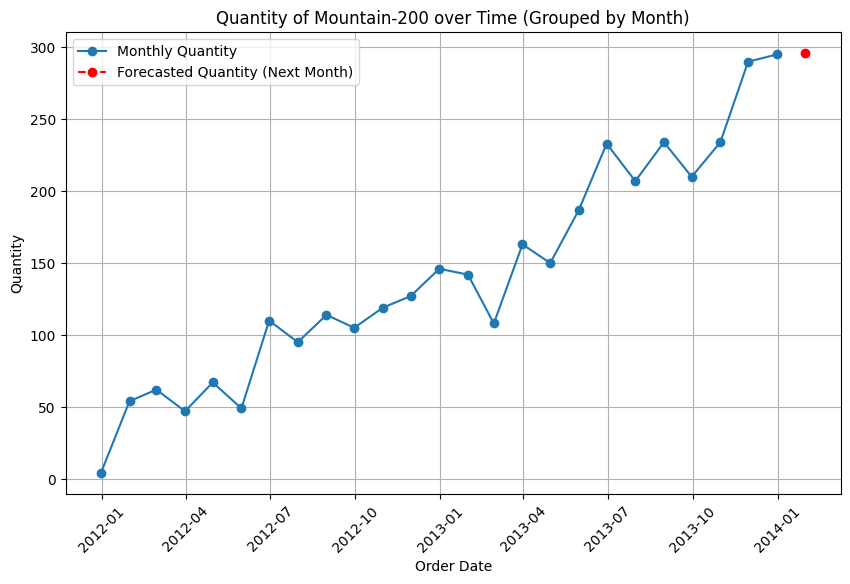

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming df_dp is your DataFrame

# Print unique ModelNames
unique_model_names = df_dp['ModelName'].unique()
print("Choose from the following ModelNames: ", unique_model_names)

# Take user input for the ModelName
chosen_model = input("Enter the ModelName from the list above: ")

# Filter the DataFrame based on the chosen ModelName
chosen_model_df = df_dp[df_dp['ModelName'] == chosen_model]

# Convert OrderDate to datetime
chosen_model_df['OrderDate'] = pd.to_datetime(chosen_model_df['OrderDate'])

# Group by month and year
chosen_model_df = chosen_model_df.set_index('OrderDate')
chosen_model_df_monthly = chosen_model_df.resample('M').sum()

# Plot the historical data
plt.figure(figsize=(10, 6))
plt.plot(chosen_model_df_monthly.index, chosen_model_df_monthly['Quantity'], marker='o', linestyle='-', label='Monthly Quantity')

# Train an ARIMA model
order = (1, 1, 1)  # You may need to adjust these parameters based on your data and requirements
model = ARIMA(chosen_model_df_monthly['Quantity'], order=order)
fit_model = model.fit()

# Forecast the next month with confidence interval
forecast_result = fit_model.get_forecast(steps=1, alpha=0.05)  # 0.05 corresponds to 95% confidence interval

# Extract forecast, stderr, and confidence interval
next_month_forecast = forecast_result.predicted_mean.values[0]
conf_int = forecast_result.conf_int()

# Extract lower and upper bounds
lower_bound, upper_bound = conf_int.iloc[0, 0], conf_int.iloc[0, 1]

# Plot the forecast for the next month
plt.plot(pd.date_range(chosen_model_df_monthly.index[-1], periods=2, freq='M')[1:], [next_month_forecast], marker='o', linestyle='--', color='r', label='Forecasted Quantity (Next Month)')

plt.title(f'Quantity of {chosen_model} over Time (Grouped by Month)')
plt.xlabel('Order Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)

# Print confidence interval
confidence_level = 100 * (1 - 0.05)
print(f"The forecasted quantity for the next month is between {lower_bound:.2f} and {upper_bound:.2f} with {confidence_level}% confidence.")

plt.legend()
plt.grid()
plt.show()
